<a href="https://colab.research.google.com/github/ericburdett/cs601r-dl/blob/master/ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition on Handwritten Documents

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
from PIL import Image, ImageOps
import gc
import pdb
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "Request a GPU from Runtime > Change Runtime"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "drive/My Drive/datasets/esposalles.zip" "/content"

In [0]:
!unzip -q esposalles.zip
!rm esposalles.zip

In [0]:
class EsposallesDataset(Dataset):
  def __init__(self, label='category', img_size=128):
    if not os.path.exists('/content/labels.csv'):
      raise Exception('Esposalles dataset does not exist in /content/labels.csv')

    self.img_size = img_size
    self.label = label
    self.path = '/content/Images/'
    self.labels_df = pd.read_csv('/content/labels.csv', sep='\t', header=None, names=['word', 'category', 'person', 'transcription', 'page'])

    unique_labels = self.labels_df[label].drop_duplicates().values

    self.num_to_label = dict()
    self.label_to_num = dict()


    for index, label in zip(range(len(unique_labels)), unique_labels):
      self.num_to_label[index] = label
      self.label_to_num[label] = index

  def dicts(self):
    return self.num_to_label, self.label_to_num
  
  def num_labels(self):
    return len(self.num_to_label)

  def resize(self, img):
    old_size = img.size
    ratio = float(self.img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    img = img.resize(new_size, Image.ANTIALIAS)

    new_img = Image.new("RGB", (self.img_size, self.img_size))
    new_img.paste(img, ((self.img_size-new_size[0])//2,
                        (self.img_size-new_size[1])//2))
    
    return new_img

  def df(self):
    return self.labels_df

  def open_image(self, path):
    img = Image.open(path + '.png')
    img = self.resize(img)
    x = transforms.functional.to_tensor(img)
    # x = x.view(-1, self.img_size ** 2) # Shape the image tensor in a way that can be consumable by the GRU

    return x

  def __getitem__(self, index):    
    pages = self.labels_df[self.labels_df['page'] == index]

    imgs = []
    labels = []

    for _, row in pages.iterrows():
      img = self.open_image(self.path + row['word'])
      label_text = row[self.label]
      label_num = self.label_to_num[label_text]

      imgs.append(img)
      labels.append(label_num)

    return imgs, labels

  def __len__(self):
    return len(self.labels_df['page'].drop_duplicates()) 

In [0]:
class RNN(nn.Module):
  def __init__(self, in_channels, hidden_channel_size, input_size, hidden_size, output_size, num_layers=1):
    super(RNN, self).__init__()

    self.in_channels = in_channels
    self.hidden_channel_size = hidden_channel_size
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers

    self.conv1 = nn.Conv2d(self.in_channels, self.hidden_channel_size, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(self.hidden_channel_size, self.hidden_channel_size, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(self.hidden_channel_size, 1, kernel_size=3, padding=1)
    self.gru = nn.GRU(input_size**2, hidden_size, num_layers)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, input_img, hidden):
    # input_img = input_img.unsqueeze(0) # unsqueeze to comply with mini-batch for conv2d
    out = self.conv1(input_img)
    out = self.conv2(out)
    out = self.conv3(out)
    out = out.view(1, -1, self.input_size**2) # reshape to expected shape for gru
    out, hidden = self.gru(out, hidden)
    out = self.linear(out)

    return out.view(-1), hidden

  def init_hidden(self):
    return torch.zeros(self.num_layers, 1, self.hidden_size).cuda()

In [0]:
NUM_EPOCHS = 25
input_size = 20


dataset = EsposallesDataset(img_size=input_size)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(.8 * len(dataset)) + 1, int(.2 * len(dataset))])

train_loader = DataLoader(train_dataset,
                          batch_size=1,
                          num_workers=8,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=1,
                        num_workers=8,
                        shuffle=True)


hidden_size = 200
hidden_channel_size = 50
output_size = dataset.num_labels()
num_layers = 30

model = RNN(3, hidden_channel_size, input_size, hidden_size, output_size, num_layers=3)
model = model.cuda()


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-3, step_size_up=200)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: .85)

objective = nn.CrossEntropyLoss()

# input_lengths = torch.full(size=(1,), fill_value=3, dtype=torch.long)
# target_lengths = torch.randint(low=3, high=4, size=(1,), dtype=torch.long)

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

predictions = []
actual = []

for epoch in range(NUM_EPOCHS):
  loop = tqdm(total=len(train_loader), position=0, leave=True)

  avg_accs = []
  avg_losses = []

  for batch, (x, y_truth) in enumerate(train_loader):
    loss = 0
    hidden = model.init_hidden()
    optimizer.zero_grad()

    accs = []
    losses = []

    for word, label in zip(x, y_truth):
      word, label = word.cuda(async=True), label.cuda(async=True)
      pred, hidden = model(word, hidden)

      acc = torch.eq(pred.argmax(), label)
      ls = objective(pred.unsqueeze(0), label) # - For CTCLoss() ->  , input_lengths, target_lengths)

      accs.append(acc.item())
      losses.append(ls.item())

      loss += ls

    loss.backward()
    optimizer.step()
    # scheduler.step()

    avg_accs.append(np.mean(accs))
    avg_losses.append(np.mean(losses))

    loop.set_description('Epoch:{}, Loss:{:.4f}, Acc:{:.4f}, AvgLoss:{:.4f}, AvgAcc:{:.4f}'.format(epoch, np.mean(losses), np.mean(accs), np.mean(avg_losses), np.mean(avg_accs)))
    loop.update(1)
  
  loop.close()
  scheduler.step()

  train_acc_list.append(np.mean(avg_accs))
  train_loss_list.append(np.mean(avg_losses))
  
  with torch.no_grad():
    val_loop = tqdm(total=len(val_loader), position=0, leave=True)

    avg_accs = []
    avg_losses = []

    for batch, (x, y_truth) in enumerate(val_loader):
      hidden = model.init_hidden()

      losses = []
      accs = []

      for word, label in zip(x, y_truth):
        word, label = word.cuda(async=True), label.cuda(async=True)
        pred, hidden = model(word, hidden)

        acc = torch.eq(pred.argmax(), label)
        ls = objective(pred.unsqueeze(0), label)

        if epoch == NUM_EPOCHS - 1:
          predictions.append(pred.argmax().item())
          actual.append(label.item())

        accs.append(acc.item())
        losses.append(ls.item())

      avg_accs.append(np.mean(accs))
      avg_losses.append(np.mean(losses))

      val_loop.set_description('Validation - Epoch:{}, Loss:{:.4f}, Acc:{:.4f}, AvgLoss:{:.4f}, AvgAcc:{:.4f}'.format(epoch, np.mean(losses), np.mean(accs), np.mean(avg_losses), np.mean(avg_accs)))
      val_loop.update(1)

    val_acc_list.append(np.mean(avg_accs))
    val_loss_list.append(np.mean(avg_losses))

Epoch:2, Loss:0.0716, Acc:1.0000, AvgLoss:0.1643, AvgAcc:0.9500:  59%|█████▉    | 457/775 [01:04<00:45,  6.95it/s]

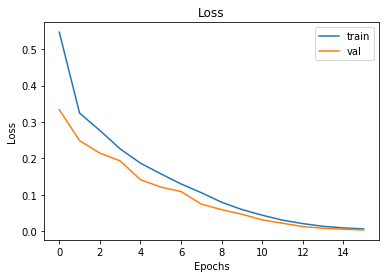

In [52]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(len(train_loss_list)), train_loss_list, label='train')
plt.plot(range(len(val_loss_list)), val_loss_list, label='val')
plt.legend()
plt.show()

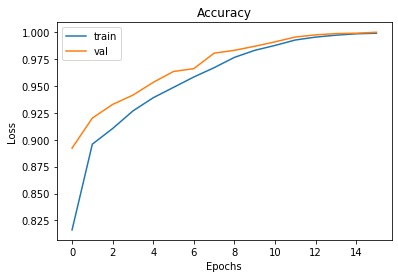

In [53]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(len(train_acc_list)), train_acc_list, label='train')
plt.plot( range(len(val_acc_list)), val_acc_list, label='val')
plt.legend()
plt.show()

In [50]:
matrix = confusion_matrix(predictions, actual)
print(matrix)

[]


In [51]:
plt.figure(figsize = (16, 10))
sns.heatmap(matrix, annot=True, fmt='d')

plt.title('Confusion Matrix', fontdict={'fontsize': 30})
plt.xlabel('Predicted', fontdict={'fontsize': 20})
plt.ylabel('Actual', fontdict={'fontsize': 20})

ValueError: ignored

<Figure size 1152x720 with 0 Axes>